In [7]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
from tslearn.utils import to_time_series, to_time_series_dataset
from tslearn.metrics import dtw

%load_ext autoreload
%autoreload 2

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve
from sklearn.pipeline import Pipeline
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm


from automltsad.detectors import TrivialDetector, KNN, WindowingDetector,OCSVM, IsolationForestAD, LOF, RandomForest, DWTMLEAD
from automltsad.transform import MeanVarianceScaler
from automltsad.utils import sliding_window_sequences, reduce_window_scores, sliding_target_window_sequences
from automltsad.metrics import average_precision_score, roc_auc_score, f1_pa, f1_pa_auc_score, f1_pa_curve, mass_volume_curve, mass_volume_auc_score, mv_feature_subsampling_auc_score

warnings.filterwarnings('ignore')

# _LOGGER = logging.getLogger('automltsad')
# _LOGGER.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter(
#     '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
# )
# ch.setFormatter(formatter)
# _LOGGER.addHandler(ch)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FILE_ID = 5
print(sorted(os.listdir('./data'))[FILE_ID])

file = sorted(os.listdir('./data'))[FILE_ID]

test_start, anomaly_start, anomaly_end = [
    int(i) for i in file.split('.')[0].split('_')[-3:]
]

a = np.loadtxt(f'./data/{file}')
a = to_time_series_dataset(a)


train = a[:,:test_start]
test = a[:,test_start:]
label = np.zeros_like(test)
label[:,anomaly_start-test_start:anomaly_end-test_start] = 1
# label = np.zeros_like(a)
# label[:,anomaly_start:anomaly_end] = 1
label = np.squeeze(label)

WINDOW_SIZE = 8
PREDICTOR_SIZE = 8
TARGET_SIZE = 1

006_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature2_4000_5703_5727.txt


## Random forest

In [97]:
from automltsad.evaluation import walk_forward_validation

X, y = sliding_target_window_sequences(
    data=a[:,3800:],
    predictor_size=64,
    target_size=1
)

anomaly_scores = []
for i, (train_idx, test_idx) in enumerate(tqdm(walk_forward_validation(data=X,window_size=64,keep_history=False, target_size=8, axis=0), total=540)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    det = RandomForest(n_estimators=100)
    det.fit(X_train, y_train)
    anomaly_scores.append(det.predict_anomaly_scores(X_test, y_test))


 99%|█████████▊| 532/540 [02:35<00:02,  3.43it/s]


## TES

In [138]:
anomaly_scores = []
for i, (train_idx, test_idx) in enumerate(tqdm(walk_forward_validation(data=a,window_size=128,keep_history=False, target_size=8, axis=1), total=4500)):
    train, test = a[:,train_idx], a[:,test_idx]
    det = ExponentialSmoothing(
        train[0],
        seasonal_periods=4,
        trend="add",
        seasonal="add",
        damped_trend=True,
        use_boxcox=True,
        initialization_method="estimated"
    )
    fitted_model = det.fit()
    pred = fitted_model.forecast(8)
    anomaly_scores.append(np.abs(pred - np.squeeze(test)))

 22%|██▏       | 1007/4500 [02:06<07:18,  7.96it/s]


In [134]:
np.array(anomaly_scores).shape

(1007, 8)

In [135]:
anomaly_scores = np.array(anomaly_scores)
anomaly_scores = anomaly_scores.flatten()
anomaly_scores = anomaly_scores[-test.shape[1]:]


In [137]:
anomaly_scores

array([ 0.2244961 ,  1.11829859,  4.28495412,  6.11226523,  8.13269803,
        8.78681222, 10.01924452, 10.90531736])

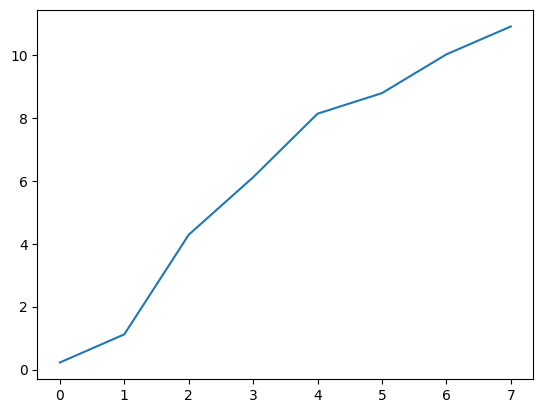

In [136]:
plt.plot(np.array(anomaly_scores))


## Test

In [70]:

# trainw = sliding_window_sequences(train, 8)
# trainw.shape
# s = MeanVarianceScaler()
# s.fit(trainw)
# s.transform(trainw)

# n_s, n_t, _ = trainw.shape
# trainw = trainw.reshape(n_s, n_t)

# n_s, n_t, _ = testw.shape
# testw = testw.reshape(n_s, n_t)


# slr = TimeSeriesScalerMeanVariance()

det = WindowingDetector(
    KNN(),
    window_size = 128,
    standardize=True
)

# det = DWTMLEAD(l=1)
det.fit(train)
anomaly_scores = det.predict_anomaly_scores(test)

# test_labels = det.predict(testw)

# scl_train = slr.fit_transform(train)
# det.fit(scl_train)
# scl_test = slr.transform(test)
# scores = det.predict_anomaly_scores(scl_test)

7.078806652270676
1.0


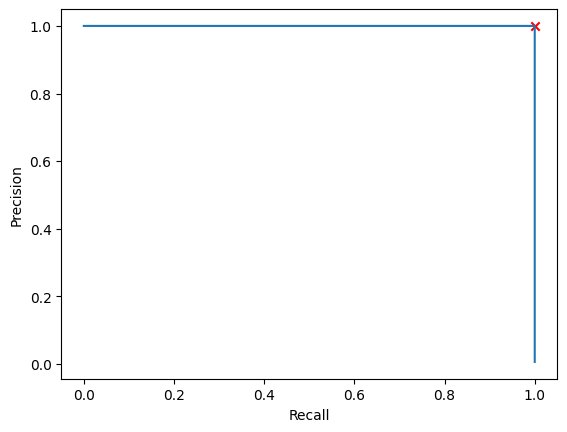

In [72]:
p, r, t = precision_recall_curve(label, anomaly_scores)
f1 = 2*p*r / (p+r)
idx = np.nanargmax(f1)
PrecisionRecallDisplay(p, r).plot()
plt.scatter(r[idx], p[idx], marker='x', color='red', label='Best')
best_t = t[idx]
best_f1 = f1[idx]
print(t[idx])
print(f1[idx])


In [73]:
f1_pa(label, anomaly_scores, best_t, k=0)

1.0

In [74]:
f1_pa_auc_score(label, anomaly_scores, best_t)

0.9989361702127659

(0.0, 1.0)

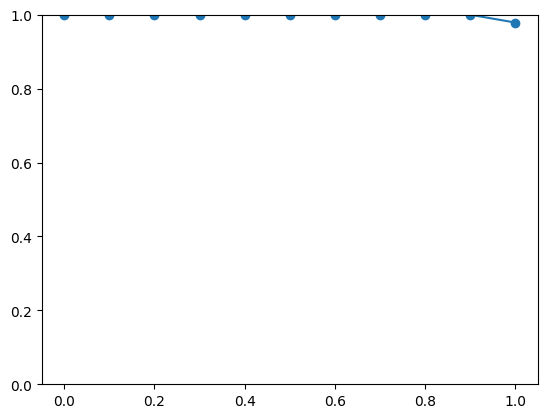

In [75]:
x, y = f1_pa_curve(label, anomaly_scores, best_t)
plt.plot(x, y, marker='o')
plt.ylim(0,1)

In [76]:
roc_auc_score(label, anomaly_scores)

1.0

In [77]:
average_precision_score(label, anomaly_scores)

0.9999999999999999

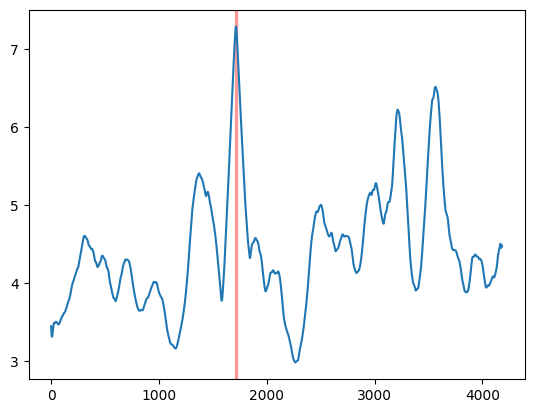

In [78]:
plt.plot(anomaly_scores)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)


In [79]:
anomaly_start-test_start, anomaly_end-test_start

(1703, 1727)

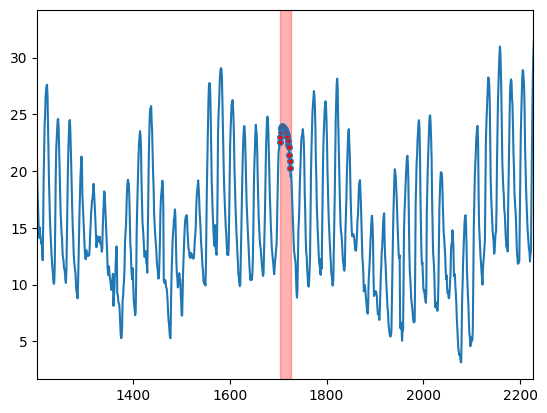

In [80]:
plt.plot(test[0], markevery=(anomaly_scores>best_t).reshape(-1).nonzero()[0], **dict(ms=4, marker='o', markerfacecolor='red'))
plt.xlim(anomaly_start-test_start - 500, anomaly_end-test_start + 500)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)
plt.show()

(0.0, 3000.0)

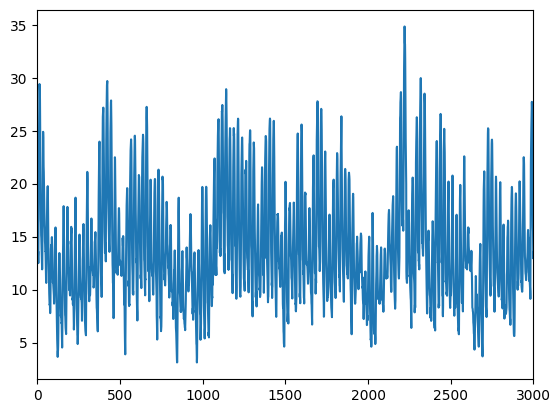

In [81]:
plt.plot(train[0])
plt.xlim((0,3000))

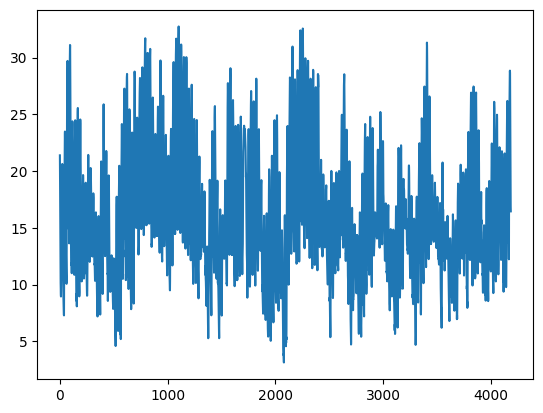

In [82]:
plt.plot(test[0])

In [83]:
anomaly_scores

array([3.44974506, 3.41167452, 3.37643354, ..., 4.47706535, 4.47828242,
       4.47906139])

## MV

f1 0.027624309392265196
mv auc 162.18416184456245
sub mv auc 9.133333945203303
f1 0.1322314049586777
mv auc 456904.3854315067
sub mv auc 5.073993899337351
f1 0.4090909090909091
mv auc 16875808425262.234
sub mv auc 9.969906046153003
f1 0.9411764705882353
mv auc 0.0
sub mv auc 21.420835706194744
f1 1.0
mv auc 0.0
sub mv auc 36.51939989734263


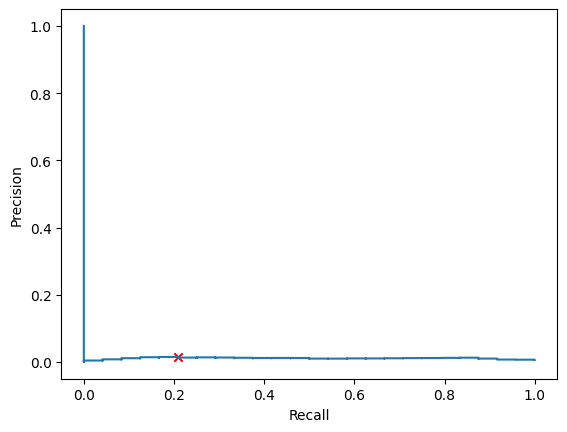

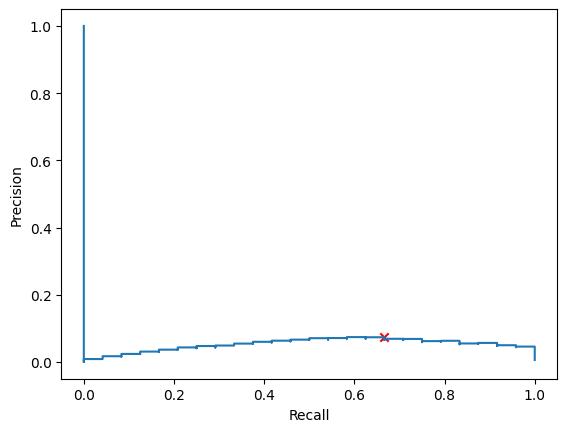

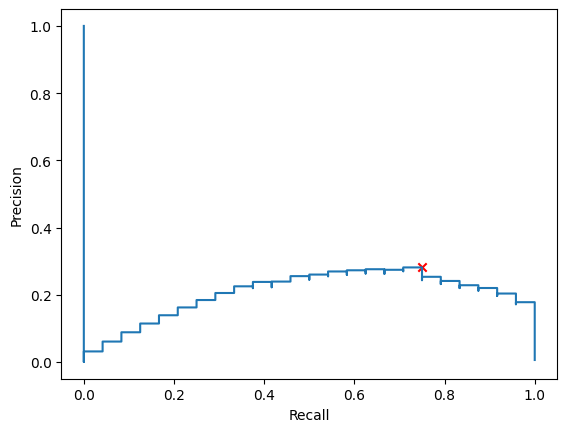

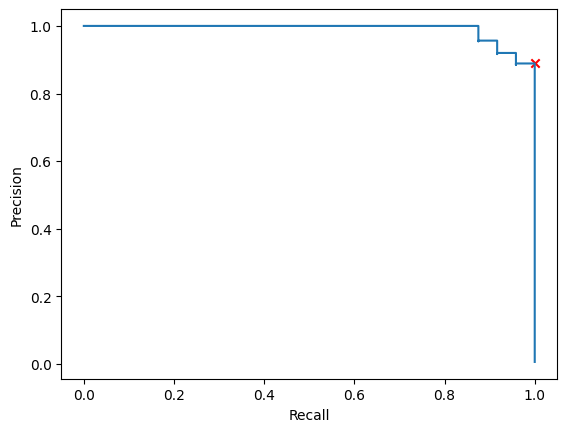

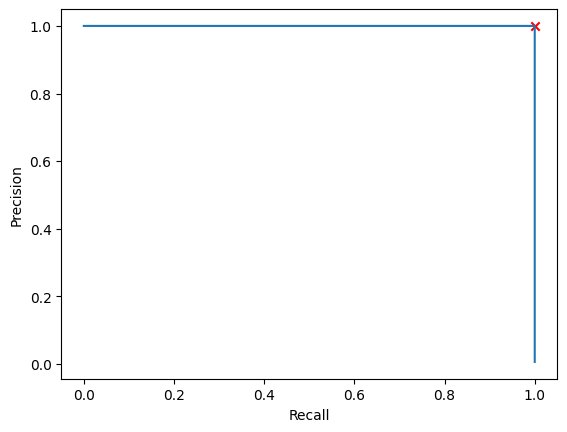

In [26]:
for ws in [8, 16, 32, 64, 128]:
    WINDOW_SIZE = ws
    trainw = sliding_window_sequences(train, WINDOW_SIZE)
    testw = sliding_window_sequences(test, WINDOW_SIZE)
    slr = MeanVarianceScaler()
    trainw = slr.fit_transform(trainw)
    testw = slr.transform(testw)

    det = KNN()
    det.fit(trainw)
    anomaly_scores = det.predict_anomaly_scores(testw)
    anomaly_scores = reduce_window_scores(anomaly_scores, WINDOW_SIZE)

    p, r, t = precision_recall_curve(label, anomaly_scores)
    f1 = 2*p*r / (p+r)
    idx = np.nanargmax(f1)
    PrecisionRecallDisplay(p, r).plot()
    plt.scatter(r[idx], p[idx], marker='x', color='red', label='Best')
    best_t = t[idx]
    best_f1 = f1[idx]

    print(f'f1 {f1[idx]}')
    print(f'mv auc {mass_volume_auc_score(det, testw)}')
    print(f'sub mv auc {mv_feature_subsampling_auc_score(det, trainw, testw)}')

7.078806652270676
1.0


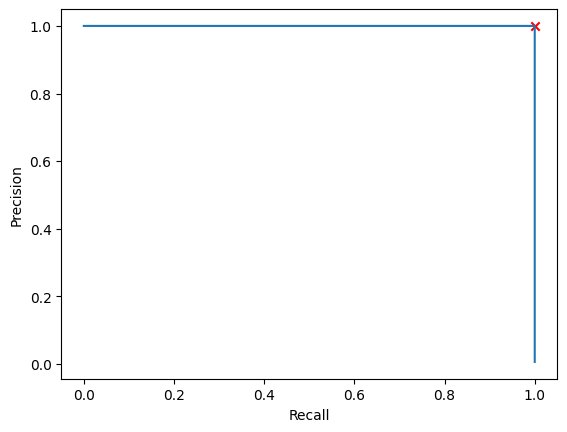

In [23]:
p, r, t = precision_recall_curve(label, anomaly_scores)
f1 = 2*p*r / (p+r)
idx = np.nanargmax(f1)
PrecisionRecallDisplay(p, r).plot()
plt.scatter(r[idx], p[idx], marker='x', color='red', label='Best')
best_t = t[idx]
best_f1 = f1[idx]
print(t[idx])
print(f1[idx])


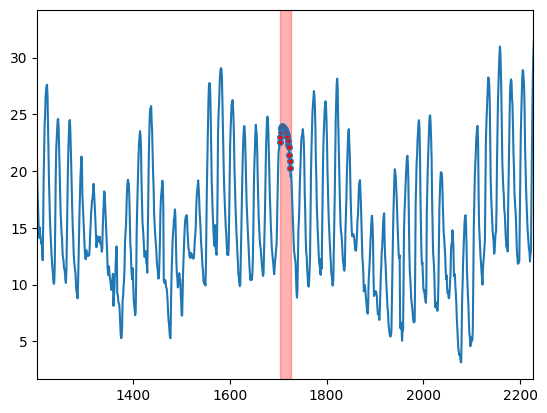

In [24]:
plt.plot(test[0], markevery=(anomaly_scores>best_t).reshape(-1).nonzero()[0], **dict(ms=4, marker='o', markerfacecolor='red'))
plt.xlim(anomaly_start-test_start - 500, anomaly_end-test_start + 500)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)
plt.show()

In [25]:
print(mass_volume_auc_score(det, testw))
print(mv_feature_subsampling_auc_score(det, trainw, testw))

0.0
37.11636054465546
